In [1]:
!pip install transformers

In [2]:
import pandas as pd
import numpy as np

import torch

from sklearn.metrics import f1_score, accuracy_score, confusion_matrix
from sklearn.model_selection import train_test_split

In [3]:
df = pd.read_csv('SpamCollectionSMS.txt',sep='\t',header=None, names=['label', 'sms'])

In [4]:
df.head()

,label,sms
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5572 entries, 0 to 5571
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   label   5572 non-null   object
 1   sms     5572 non-null   object
dtypes: object(2)
memory usage: 87.2+ KB


<Axes: >

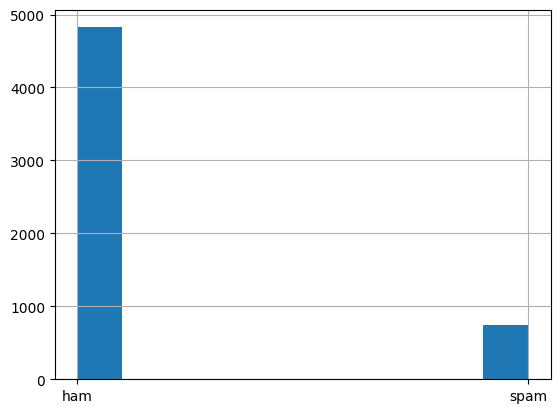

In [6]:
df['label'].hist()

In [7]:
# convert label to numeric
target_map = { 'ham': 0, 'spam': 1}
df['target'] = df['label'].map(target_map)

In [8]:
df.head()

,label,sms,target
0,ham,"Go until jurong point, crazy.. Available only ...",0
1,ham,Ok lar... Joking wif u oni...,0
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,1
3,ham,U dun say so early hor... U c already then say...,0
4,ham,"Nah I don't think he goes to usf, he lives aro...",0


In [9]:
#  rename columns to sentence and label
df1 = df[['sms','target']]
df1.columns = ['sentence','label']
df1.to_csv('data.csv', index = False)

In [10]:
df1.head()


,sentence,label
0,"Go until jurong point, crazy.. Available only ...",0
1,Ok lar... Joking wif u oni...,0
2,Free entry in 2 a wkly comp to win FA Cup fina...,1
3,U dun say so early hor... U c already then say...,0
4,"Nah I don't think he goes to usf, he lives aro...",0


In [11]:
!pip install datasets

In [12]:
from datasets import load_dataset
raw_dataset = load_dataset('csv', data_files = 'data.csv')

Extracting data files:   0%|          | 0/1 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

In [13]:
raw_dataset

DatasetDict({
    train: Dataset({
        features: ['sentence', 'label'],
        num_rows: 5572
    })
})

In [14]:
# split dataset into train and test
split = raw_dataset['train'].train_test_split(test_size=0.3)


In [15]:
split

DatasetDict({
    train: Dataset({
        features: ['sentence', 'label'],
        num_rows: 3900
    })
    test: Dataset({
        features: ['sentence', 'label'],
        num_rows: 1672
    })
})

In [16]:

# Import AutoTokenizer and create tokenizer object
from transformers import AutoTokenizer
model_name = 'albert-base-v2'
tokernizer = AutoTokenizer.from_pretrained(model_name)

In [17]:
# tokenize dataset using tokenizer 
def tokenize_fn(batch):
  return tokernizer(batch['sentence'], truncation = True)

In [18]:
tokenized_dataset = split.map(tokenize_fn, batched = True)

Map:   0%|          | 0/3900 [00:00<?, ? examples/s]

Map:   0%|          | 0/1672 [00:00<?, ? examples/s]

In [19]:
tokenized_dataset

DatasetDict({
    train: Dataset({
        features: ['sentence', 'label', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 3900
    })
    test: Dataset({
        features: ['sentence', 'label', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 1672
    })
})

In [20]:
label2id =  { 'ham': 0, 'spam': 1}
id2label =  { 0:'ham', 1: 'spam'}

In [21]:
pip install --upgrade huggingface_hub

In [22]:
from transformers import AutoModelForSequenceClassification, Trainer, TrainingArguments
model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels = 2)

Some weights of AlbertForSequenceClassification were not initialized from the model checkpoint at albert-base-v2 and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [23]:
!pip install torchinfo
from torchinfo import summary
summary(model)

Layer (type:depth-idx)                                       Param #
AlbertForSequenceClassification                              --
├─AlbertModel: 1-1                                           --
│    └─AlbertEmbeddings: 2-1                                 --
│    │    └─Embedding: 3-1                                   3,840,000
│    │    └─Embedding: 3-2                                   65,536
│    │    └─Embedding: 3-3                                   256
│    │    └─LayerNorm: 3-4                                   256
│    │    └─Dropout: 3-5                                     --
│    └─AlbertTransformer: 2-2                                --
│    │    └─Linear: 3-6                                      99,072
│    │    └─ModuleList: 3-7                                  7,087,872
│    └─Linear: 2-3                                           590,592
│    └─Tanh: 2-4                                             --
├─Dropout: 1-2                                               --
├─Line

In [24]:
!pip install transformers[torch]
!pip install accelerate -U

In [25]:
# 
training_args = TrainingArguments(output_dir='training_dir', # output directory
                                  evaluation_strategy='epoch', 
                                  save_strategy='epoch',   
                                  num_train_epochs=10, # total number of training epochs
                                  per_device_train_batch_size=16,
                                  per_device_eval_batch_size=64,
                                  )

In [26]:
def compute_metrics(logits_and_labels):
  logits, labels = logits_and_labels
  predictions = np.argmax(logits, axis=-1)
  acc = np.mean(predictions == labels)
  f1 = f1_score(labels, predictions, average = 'micro')
  return {'accuracy': acc, 'f1_score': f1}

In [27]:
trainer = Trainer(model,
                  training_args,
                  train_dataset = tokenized_dataset["train"],
                  eval_dataset = tokenized_dataset["test"],
                  tokenizer=tokernizer,
                  compute_metrics=compute_metrics)

In [28]:

trainer.train()

You're using a AlbertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


Epoch,Training Loss,Validation Loss,Accuracy,F1 Score
1,No log,0.106961,0.978469,0.978469
2,No log,0.067349,0.988038,0.988038
3,0.088500,0.029282,0.994617,0.994617
4,0.088500,0.027998,0.996411,0.996411
5,0.030600,0.035516,0.995215,0.995215
6,0.030600,0.036356,0.995215,0.995215
7,0.008700,0.044800,0.994617,0.994617
8,0.008700,0.061814,0.992225,0.992225
9,0.004700,0.042048,0.994617,0.994617
10,0.004700,0.039270,0.994617,0.994617


TrainOutput(global_step=2440, training_loss=0.028083139951111842, metrics={'train_runtime': 559.7438, 'train_samples_per_second': 69.675, 'train_steps_per_second': 4.359, 'total_flos': 120765509869680.0, 'train_loss': 0.028083139951111842, 'epoch': 10.0})

In [29]:
! ls training_dir

checkpoint-1220  checkpoint-1952  checkpoint-2440  checkpoint-976
checkpoint-1464  checkpoint-2196  checkpoint-488   runs
checkpoint-1708  checkpoint-244   checkpoint-732


In [30]:

from transformers import pipeline

In [32]:
# load the saved model from the latest checkpoint

saved_model = pipeline('text-classification',
                       model = 'training_dir/checkpoint-2440')

In [33]:
split['test']


Dataset({
    features: ['sentence', 'label'],
    num_rows: 1672
})

In [34]:
# predict on test dataset
prediction = saved_model(split['test']['sentence'])

In [35]:
def get_label(d):
  return int(d['label'].split('_')[1])
predictions = [get_label(d) for d in prediction]

In [36]:
print("acc:",accuracy_score(split['test']['label'], predictions))

acc: 0.9946172248803827


In [37]:
print("f1:",f1_score(split['test']['label'], predictions, average = 'macro'))

f1: 0.9880615297712031


In [39]:
import seaborn as sns

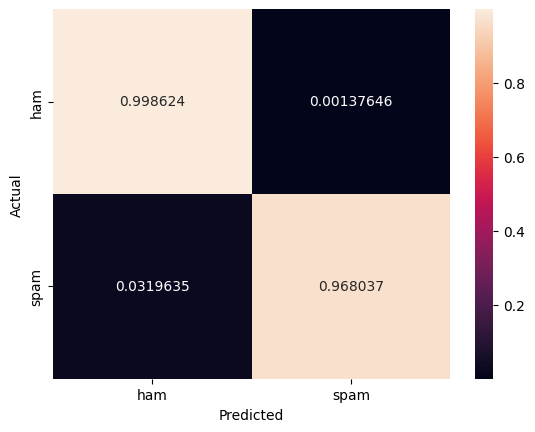

In [43]:
# create function for plotting confusion matrix
def plot_cm(cm):
  classes = ['ham','spam']
  df_cm = pd.DataFrame(cm, index=classes, columns=classes)
  ax = sns.heatmap(df_cm, annot = True, fmt='g')
  ax.set_xlabel('Predicted')
  ax.set_ylabel('Actual')

cm = confusion_matrix(split['test']['label'],predictions, normalize = 'true')
plot_cm(cm)

In [44]:
 saved_model(['Hi John, just a reminder of our meeting tomorrow at 2 PM at the office. Please make sure to bring the presentation materials with you. Looking forward to it!'])

[{'label': 'LABEL_0', 'score': 0.9985975623130798}]

In [45]:
saved_model(['''FreeMsg Hey there darling it's been 3 week's now and no word back! I'd like some fun you up for it still? Tb ok! XxX std chgs to send, å£1.50 to rcv'''])

[{'label': 'LABEL_1', 'score': 0.9995067119598389}]

In [52]:
from huggingface_hub import notebook_login
notebook_login()

In [51]:
# save the model to huggingface hub
trainer.push_to_hub("albert-spam-sms-classification-finetuned")

Upload 2 LFS files:   0%|          | 0/2 [00:00<?, ?it/s]

pytorch_model.bin:   0%|          | 0.00/46.7M [00:00<?, ?B/s]

training_args.bin:   0%|          | 0.00/4.03k [00:00<?, ?B/s]

'https://huggingface.co/SidharthanRajendran/training_dir/tree/main/'

In [53]:
# load the saved model from huggingface hub
saved_model = pipeline('text-classification',
                       model = 'Sanrove/albert-spam-sms-classification-finetuned')

In [54]:
 saved_model(['Hi John, just a reminder of our meeting tomorrow at 2 PM at the office. Please make sure to bring the presentation materials with you. Looking forward to it!'])

[{'label': 'LABEL_0', 'score': 0.9985975623130798}]

In [55]:
saved_model(['''FreeMsg Hey there darling it's been 3 week's now and no word back! I'd like some fun you up for it still? Tb ok! XxX std chgs to send, å£1.50 to rcv'''])

[{'label': 'LABEL_1', 'score': 0.9995067119598389}]